In [2]:
""" Create a meshgrid for which two lat & lon can be created for Hubbard Brook that are within 
    the same aerosol deposition grids. 
"""
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np

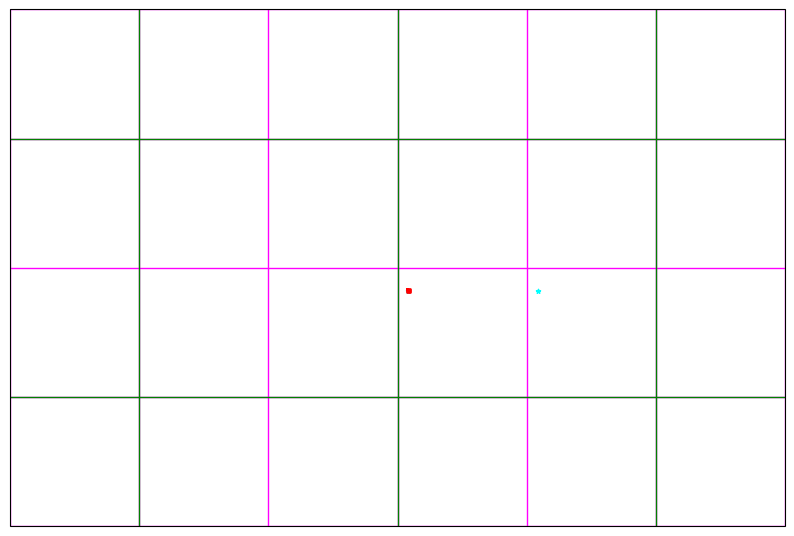

In [3]:
""" Check if the selected locations for the "upland" site ("watershed_mean")
    and the "lowland" site ("watershed_shifted") safely resides in the same
    meteorological grid (0.5x0.5) and land surface grid (0.9x1.25), but 
    different 1km grids. 
"""
lon_bigger = np.arange(0, 360, 2.5)
lat_bigger = np.linspace(-90, 90, 96)

lon_smaller = np.arange(-179.75, 179.76, 0.5)
lat_smaller = np.arange(-89.75, 89.76, 0.5)

lon_25km = np.linspace(-180, 180, 1441)
lat_25km = np.linspace(-90, 90, 721)

watershed = [-71.731339, -71.726311, 43.959286, 43.952053]
watershed_mean = (-71.728825, 43.9556695)
watershed_shifted = (-71.728825 + 0.25, 43.9556695)

bbox = [-72.5, -71, 43.5, 44.5]

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.coastlines()

for lat,lon in zip(lat_25km, lon_25km):
    if (lat >= bbox[2]) & (lat <= bbox[3]):
        ax.axhline(lat, color = 'magenta', lw = 1)
    if (lon >= bbox[0]) & (lon <= bbox[1]):
        ax.axvline(lon, color = 'magenta', lw = 1)

for lat,lon in zip(lat_smaller, lon_smaller):
    if (lat >= bbox[2]) & (lat <= bbox[3]):
        ax.axhline(lat, color = 'g', lw = 1)
    if (lon >= bbox[0]) & (lon <= bbox[1]):
        ax.axvline(lon, color = 'g', lw = 1)

for lat,lon in zip(lat_bigger, lon_bigger):
    if (lat >= bbox[2]) & (lat <= bbox[3]):
        ax.axhline(lat, color = 'b', lw = 1)
    if (lon >= bbox[0]) & (lon <= bbox[1]):
        ax.axvline(lon, color = 'b', lw = 1)

watershed_box = [watershed[0], watershed[1], watershed[1], watershed[0], watershed[0]],\
                [watershed[2], watershed[2], watershed[3], watershed[3], watershed[2]]
ax.plot(*watershed_box, color='red', linewidth=2, transform=ccrs.PlateCarree())

ax.scatter(*watershed_mean, color = 'cyan', s = 10, marker = '*')
ax.scatter(*watershed_shifted, color = 'cyan', s = 10, marker = '*')

ax.set_extent(bbox, crs=ccrs.PlateCarree())

In [4]:
""" Create the 1km grid for enhanced weathering file
"""
time = xr.cftime_range(start='1998', end='2025', freq='1Y', calendar='noleap')

dims = ('time', 'lat', 'lon')
coords = [time, lat_25km, lon_25km]
year = xr.DataArray(time.year, dims='time')

ds = xr.Dataset({
    'ew_app': xr.DataArray(np.nan, coords, dims).astype(np.float32),
    'ew_min_1': xr.DataArray(np.nan, coords, dims).astype(np.float32),
    'ew_min_2': xr.DataArray(np.nan, coords, dims).astype(np.float32),
    'ew_min_3': xr.DataArray(np.nan, coords, dims).astype(np.float32),
    'ew_min_4': xr.DataArray(np.nan, coords, dims).astype(np.float32),
    'ew_min_5': xr.DataArray(np.nan, coords, dims).astype(np.float32),
    'ew_pho': xr.DataArray(np.nan, coords, dims).astype(np.float32),
    'ew_gra': xr.DataArray(np.nan, coords, dims).astype(np.float32),
    'ew_sph': xr.DataArray(np.nan, coords, dims).astype(np.float32),
    'ew_pct_crop': xr.DataArray(np.nan, coords, dims).astype(np.float32), 
    'YEAR': year
}, coords={'time': time, 'lat': lat_25km, 'lon': lon_25km})

ds['ew_app'].attrs = {
    'long_name': 'application rate of the rock powder',
    'unit': 'kg m-2 yr-1'
}
for i in range(1, 6):
    ds[f'ew_min_{i}'].attrs = {
        'long_name': f'percentage of mineral {i}',
        'units': '%'
    }
ds['ew_pho'].attrs = {
    'long_name': 'phosphorus content of the rock powder', 
    'units': 'gP kg-1'
}
ds['ew_gra'].attrs = {
    'long_name': 'grain size of the rock powder',
    'units': 'um'
}
ds['ew_sph'].attrs = {
    'long_name': 'soil pH if known', 
    'units': ''
}
ds['ew_pct_crop'].attrs = {
    'long_name': 'Percent applied on crop column; the rest is on natural vegetation column', 
    'units': '%'
}
ds['YEAR'].attrs = {
    'long_name': 'year',
    'units': 'Year AD'
}
ds['lat'].attrs = {
    'long_name': 'latitude', 
    'units': 'degrees north'
}
ds['lon'].attrs = {
    'long_name': 'longitude',
    'units': 'degrees east'
}


# insert the values
for (lon, lat) in [watershed_mean, watershed_shifted]:
    ind_year = np.argmin(np.abs(ds['YEAR'].values - 1999))
    lon_idx = np.argmin(np.abs(ds['lon'].values - lon))
    lat_idx = np.argmin(np.abs(ds['lat'].values - lat))

    # 55 tons / 11.8 ha = 0.466 kg / m2
    ds['ew_app'][:ind_year, lat_idx, lon_idx] = 0
    ds['ew_app'][ind_year, lat_idx, lon_idx] = 0.466
    ds['ew_app'][(ind_year+1):, lat_idx, lon_idx] = 0

    ds['ew_min_1'][:, lat_idx, lon_idx] = 100. # wollastonite, completely

    ds['ew_pho'][:, lat_idx, lon_idx] = 0 # no P

    ds['ew_gra'][:, lat_idx, lon_idx] = 9.6 # 9.6 um

    ds['ew_sph'][:ind_year, lat_idx, lon_idx] = 3.5
    ds['ew_sph'][ind_year, lat_idx, lon_idx] = 4.5 # soil pH after application
    ds['ew_sph'][(ind_year+1):, lat_idx, lon_idx] = 4.5

for var in ds.variables:
    if var in ['YEAR', 'time', 'lat', 'lon']:
        ds[var].encoding['_FillValue'] = None
    elif ds[var].dtype == np.float32:
        ds[var].encoding['_FillValue'] = 1e20

ds.to_netcdf('../data/ew_clm_hist_simyr1999_0.25x0.25_c150929.nc', format = 'NETCDF3_CLASSIC')

In [5]:
watershed_mean

(-71.728825, 43.9556695)

In [6]:
watershed_shifted

(-71.478825, 43.9556695)

: 